# MODEL TRAINING AND EVALUATION
Following the data preprocessing steps conducted in the "data_preprocessing.ipynb" file. This code file called "model_training" contains a comprehensive machine learning pipeline for essay grading using the processed data from the data_preprocessing file. 
The code contains additional text processing, model training and evaluation and, the visualization of the results.

## Text Processing
1. Tokenizing and vectorizing the essay text using Count Vectorization.
2. Generating Word2Vec word embeddings for the essay text.

## Model Training and Evaluation
1. Training and evaluating a Support Vector Machine (SVM) regression model.
2. Training and evaluating a Random Forest regression model.
3. Training and evaluating multiple layers of LSTM models with Word2Vec embeddings.
4. Saving the trained models to files for future use.


IMPORTING LIBRARIES

In [1]:
# Importing necessary libraries
import pandas as pd  # For data manipulation
import numpy as np   # For numerical operations
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For enhanced data visualization
%matplotlib inline
import warnings  # For suppressing warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import os  # For operating system-related functions

import nltk  # Natural Language Toolkit for NLP tasks

from gensim.models import Word2Vec  # For Word2Vec embeddings
import joblib #For saving and loading ML models
from sklearn.model_selection import train_test_split, KFold  # For data splitting and cross-validation
from sklearn.metrics import cohen_kappa_score, mean_squared_error, mean_absolute_error  # For evaluation metrics
from sklearn.feature_extraction.text import CountVectorizer  # For text vectorization
from sklearn.ensemble import RandomForestRegressor  # For Random Forest regression
from sklearn.svm import SVR  # For Support Vector Regression

from keras.layers import LSTM, Dense, Dropout  # For defining LSTM neural networks
from keras.models import Sequential, load_model, model_from_config  # For creating and loading Keras models


In [2]:
# Reading data from the "processed.csv" file into a DataFrame
df = pd.read_csv("processed.csv")

# Dropping the 'Unnamed: 0' column as it appears to be an extra index column
df.drop('Unnamed: 0', inplace=True, axis=1)

# Displaying the first few rows of the DataFrame to inspect the data
df.head()


,essay_id,essay_set,essay,grade,token_essay,sentence_count,word_count,unique_word_count,character_count,average_word_length,noun_count,verb_count,adj_count,adverb_count,pronoun_count,preposition_count,conjunction_count,determiner_count,misspelled_count
0,1,1,"Dear local newspaper, I think effects computer...",8,"[['Dear', 'local', 'newspaper', 'I', 'think', ...",16,179,118,935,5.223464,71,43,25,15,13,5,0,0,12
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9,"[['Dear', 'I', 'believe', 'using', 'computers'...",17,235,141,1249,5.314894,98,63,25,13,15,8,0,4,17
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7,"[['Dear', 'More', 'people', 'use', 'computers'...",14,147,105,816,5.551020,73,35,23,3,3,2,0,3,8
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10,"[['Dear', 'Local', 'Newspaper', 'I', 'found', ...",26,283,186,1678,5.929329,141,61,37,14,5,9,0,5,27
4,5,1,"Dear @LOCATION1, I know having computers has a...",8,"[['Dear', 'I', 'know', 'computers', 'positive'...",30,258,148,1391,5.391473,118,49,24,16,5,10,0,15,20


In [3]:
# Check if the "Models" directory exists; if not, create it
if not os.path.exists("Models"):
    os.mkdir("Models")



In [4]:

def visualize_results(results, title):
    """
    Visualize the results using a bar plot.

    Args:
        results (dict): A dictionary containing model names as keys and their corresponding scores as values.
        title (str): The title of the plot.
    """
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(results.keys()), y=list(results.values()))
    plt.title(title)
    plt.ylabel("Score")
    plt.xlabel("Model")
    plt.show()



 Contribution 1: Evaluation of Machine Learning Models on Linguistic and Structural Features of Essays

Count Vectorization: N-Gram Features

In [5]:
# This code uses CountVectorizer to convert text data into a bag-of-words representation
# that includes unigrams, bigrams, and trigrams, and prepares it for modeling by creating a dense array for feature extraction.

vectorizer = CountVectorizer(max_features = 1000, ngram_range=(1, 3), stop_words='english')
count_vectors = vectorizer.fit_transform(df['token_essay'])
feature_names = vectorizer.get_feature_names_out()
X_cv = count_vectors.toarray()

In [6]:
# Convert X_cv array back to a DataFrame with meaningful column names
X_cv = pd.DataFrame(X_cv, columns=feature_names)

# Display the DataFrame
X_cv.head()

,ability,able,access,accident,actually,add,add stress,adult,adults,affect,...,written,wrong,year,years,yes,york,york city,yosemite,young,younger
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Combine processed features and bag-of-words (n-grams) representation to create the feature matrix for modeling.

X1 = pd.concat([df.iloc[:, 5:], X_cv], axis = 1)
y = df['grade']
X1.head()

,sentence_count,word_count,unique_word_count,character_count,average_word_length,noun_count,verb_count,adj_count,adverb_count,pronoun_count,...,written,wrong,year,years,yes,york,york city,yosemite,young,younger
0,16,179,118,935,5.223464,71,43,25,15,13,...,0,0,0,0,0,0,0,0,0,0
1,17,235,141,1249,5.314894,98,63,25,13,15,...,0,0,0,0,0,0,0,0,0,0
2,14,147,105,816,5.551020,73,35,23,3,3,...,0,1,0,0,0,0,0,0,0,0
3,26,283,186,1678,5.929329,141,61,37,14,5,...,0,0,0,0,0,0,0,0,0,0
4,30,258,148,1391,5.391473,118,49,24,16,5,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Split the data into training and testing sets.
train_X, test_X, train_y, test_y = train_test_split(X1, y, test_size = 0.3)

SVM Model

Mean Squared Error: 53.82024856700573
Mean Absolute Error: 3.8057984530971285
Root Mean Squared Error: 7.336228497464193
Cohen's Kappa Score: 0.5373751259941353


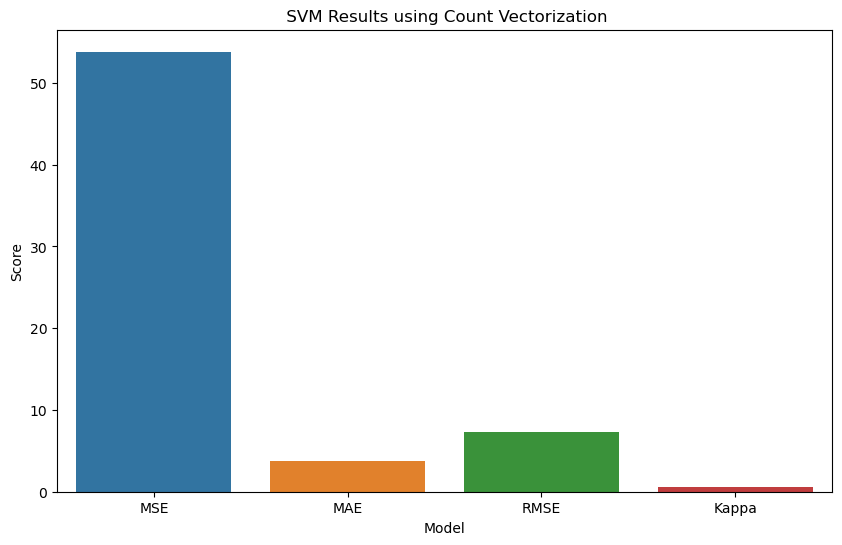

In [10]:
# Train an SVM regression model, evaluate using multiple metrics, and visualize the results.

svm = SVR(C=1.0, epsilon=0.2)
svm.fit(train_X, train_y)

# Save the SVM model to a file
joblib.dump(svm, 'Models/svm_model.pkl')

# Load the SVM model from the file
loaded_svm = joblib.load('Models/svm_model.pkl')

# Use the loaded model to make predictions
pred_y = loaded_svm.predict(test_X)


# Evaluate using MAE, MSE, RMSE, and Cohen's Kappa
mse = mean_squared_error(test_y, pred_y)
mae = mean_absolute_error(test_y, pred_y)
rmse = np.sqrt(mse)
kappa = cohen_kappa_score(test_y, np.around(pred_y), weights='quadratic')

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print("Cohen's Kappa Score:", kappa)

# Visualize results
results = {
    "MSE": mse,
    "MAE": mae,
    "RMSE": rmse,
    "Kappa": kappa
}
visualize_results(results, f" SVM Results using Count Vectorization")


Random Forest Model

Mean Squared Error: 4.760759472892941
Mean Absolute Error: 1.0631833633016525
Root Mean Squared Error: 2.181916467899938
Cohen's Kappa Score: 0.9691670940684024


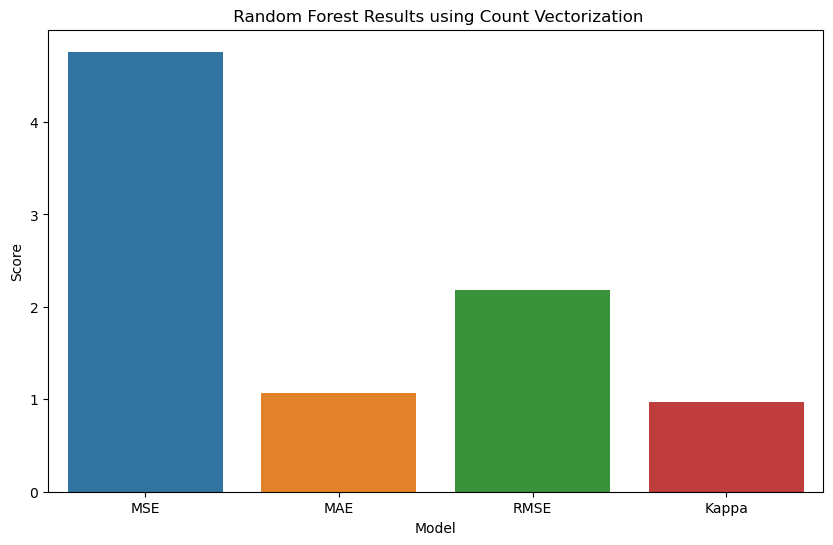

In [11]:
# Train a Random Forest regression model, evaluate using multiple metrics, and visualize the results.

rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf.fit(train_X, train_y)

# Save the RF model to a file
joblib.dump(rf, 'Models/rf_model.pkl')

# Load the RF model from the file
loaded_rf = joblib.load('Models/rf_model.pkl')

# Use the loaded model to make predictions
pred_y = loaded_rf.predict(test_X)

# Evaluate using MAE, MSE, RMSE, and Cohen's Kappa
mse = mean_squared_error(test_y, pred_y)
mae = mean_absolute_error(test_y, pred_y)
rmse = np.sqrt(mse)
kappa = cohen_kappa_score(test_y, np.around(pred_y), weights='quadratic')

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print("Cohen's Kappa Score:", kappa)

# Visualize results
results = {
    "MSE": mse,
    "MAE": mae,
    "RMSE": rmse,
    "Kappa": kappa
}
visualize_results(results, f" Random Forest Results using Count Vectorization")


Contribution 2: Evaluation of Deep Learning Models on Contextual Features of Essays

WORD EMBEDDING: Word2Vec

In [12]:
# Functions to generate feature vectors for words and essays using a Word2Vec model.

def generate_feature_vector(words, model, num_features):
    """
    Generate a feature vector for a list of words using the Word2Vec model.

    Args:
        words (list): A list of words.
        model (Word2Vec): The Word2Vec model for word embeddings.
        num_features (int): The number of features in the word embeddings.

    Returns:
        np.ndarray: The feature vector for the input list of words.
    """
    feature_vec = np.zeros(num_features, dtype="float32")
    num_words = 0

    for word in words:
        if word in model.wv:
            num_words += 1
            feature_vec = np.add(feature_vec, model.wv[word])

    if num_words > 0:
        feature_vec /= num_words

    return feature_vec

def generate_average_feature_vectors(essays, model, num_features):
    """
    Generate the average feature vectors for a list of essays using the Word2Vec model.

    Args:
        essays (list): A list of essays, where each essay is represented as a list of words.
        model: The Word2Vec model used for feature extraction.
        num_features (int): The number of features in the Word2Vec model.

    Returns:
        np.ndarray: An array of average feature vectors for each essay in the input list.
    """
    essay_feature_vecs = np.zeros((len(essays), num_features), dtype="float32")
    no_of_vec = 0

    for essay in essays:
        feature_vec = generate_feature_vector(essay, model, num_features)
        essay_feature_vecs[no_of_vec] = feature_vec
        no_of_vec += 1

    return essay_feature_vecs

2-LAYER LSTM MODEL

In [13]:
#2-Layer LSTM Model definition
def get_model():
    """
    Define a 2-layer Long Short-Term Memory (LSTM) model for regression tasks.

    Returns:
        keras.models.Sequential: A Keras Sequential model representing the defined LSTM model.
    """
    model = Sequential()
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()

    return model

In [14]:
# 2-Layer LSTM Model Training and Testing
kf = KFold(n_splits=5, shuffle=True)
mse_scores = []  # List to store Mean Squared Error (MSE) scores
rmse_scores = []  # List to store Root Mean Squared Error (RMSE) scores
mae_scores = []  # List to store Mean Absolute Error (MAE) scores
kappa_scores = []  # List to store Cohen's Kappa scores

count = 1
for trainkf, testkf in kf.split(df):
    print("\nTraining Fold {}\n".format(count))
    X_train, X_test, y_train, y_test = df.iloc[trainkf], df.iloc[testkf], y.iloc[trainkf], y.iloc[testkf]
        
    # Tokenize essays for training and testing data
    train_essays = [essay.split() for essay in X_train['token_essay']]
    test_essays = [essay.split() for essay in X_test['token_essay']]
                 
    # Initializing variables for Word2Vec model.
    num_features = 300 
    min_word_count = 40
    num_workers = 4
    context = 10
    downsampling = 1e-3

    print("Training Word2Vec Model...")
    
    # Train Word2Vec model on training essays
    model_lstm = Word2Vec(train_essays, 
                     workers=num_workers, 
                     vector_size=num_features, 
                     min_count=min_word_count, 
                     window=context, 
                     sample=downsampling)

    # Save the Word2Vec model
    model_lstm.wv.save_word2vec_format('Models/word2vecmodel_lstm2.bin', binary=True)

    # Generate average feature vectors for training and testing essays
    training_vectors = generate_average_feature_vectors(train_essays, model_lstm, num_features)
    testing_vectors = generate_average_feature_vectors(test_essays, model_lstm, num_features)

    training_vectors = np.array(training_vectors)
    testing_vectors = np.array(testing_vectors)
    
    # Reshape train and test vectors to 3 dimensions. (1 represents one timestep)
    training_vectors = np.reshape(training_vectors, (training_vectors.shape[0], 1, training_vectors.shape[1]))
    testing_vectors = np.reshape(testing_vectors, (testing_vectors.shape[0], 1, testing_vectors.shape[1]))
    
    # Create and train the 2-Layer LSTM model
    lstm_model2 = get_model()
    lstm_model2.fit(training_vectors, y_train, batch_size=64, epochs=50)
    
    y_pred = lstm_model2.predict(testing_vectors)
    
    # Save the model on the last fold
    if count == 5:
        lstm_model2.save('Models/model_lstm2.h5')
    
    # Round y_pred to the nearest integer.
    y_pred = np.around(y_pred)    
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    kappa = cohen_kappa_score(y_test.values, y_pred, weights='quadratic')
    
    print("Fold {} MSE: {}".format(count, mse))
    print("Fold {} RMSE: {}".format(count, rmse))
    print("Fold {} MAE: {}".format(count, mae))
    print("Fold {} Kappa Score: {}".format(count, kappa))
    
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    kappa_scores.append(kappa)

    count += 1



Training Fold 1

Training Word2Vec Model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 300)            721200    
                                                                 
 lstm_1 (LSTM)               (None, 64)                93440     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 814705 (3.11 MB)
Trainable params: 814705 (3.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
163/163 [==============================] - 18s 38ms/step - loss: 54.0128 - mae: 3.7394
Epoch 2/5

163/163 [==============================] - 6s 36ms/step - loss: 6.4668 - mae: 1.3516
Epoch 35/50
163/163 [==============================] - 6s 34ms/step - loss: 6.2643 - mae: 1.3245
Epoch 36/50
163/163 [==============================] - 5s 33ms/step - loss: 6.0867 - mae: 1.3178
Epoch 37/50
163/163 [==============================] - 6s 35ms/step - loss: 5.9200 - mae: 1.2973
Epoch 38/50
163/163 [==============================] - 5s 32ms/step - loss: 5.8896 - mae: 1.3060
Epoch 39/50
163/163 [==============================] - 5s 34ms/step - loss: 6.1167 - mae: 1.3125
Epoch 40/50
163/163 [==============================] - 5s 32ms/step - loss: 6.0062 - mae: 1.3008
Epoch 41/50
163/163 [==============================] - 5s 31ms/step - loss: 5.8603 - mae: 1.2976
Epoch 42/50
163/163 [==============================] - 5s 32ms/step - loss: 6.1031 - mae: 1.3154
Epoch 43/50
163/163 [==============================] - 5s 31ms/step - loss: 5.7108 - mae: 1.2792
Epoch 44/50
163/163 [=====================

                                                                 
 lstm_9 (LSTM)               (None, 64)                93440     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 814705 (3.11 MB)
Trainable params: 814705 (3.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
163/163 [==============================] - 12s 31ms/step - loss: 53.2198 - mae: 3.7638
Epoch 2/50
163/163 [==============================] - 5s 32ms/step - loss: 29.5805 - mae: 2.5539
Epoch 3/50
163/163 [==============================] - 5s 34ms/step - loss: 20.9627 - mae: 2.2726
Epoch 4/50
163/163 [==============================] - 5s 33ms/step - loss: 15.

C:\Users\yabio\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Fold 5 MSE: 4.633911368015414
Fold 5 RMSE: 2.152652170699069
Fold 5 MAE: 1.0701348747591521
Fold 5 Kappa Score: 0.9697319774806


Average MSE for LSTM 2-layers:  4.863922352752568
Average RMSE for LSTM 2-layers:  2.2042291839259596
Average MAE for LSTM 2-layers:  1.1160611404532244
Average Kappa for LSTM 2-layers:  0.9695073937594266


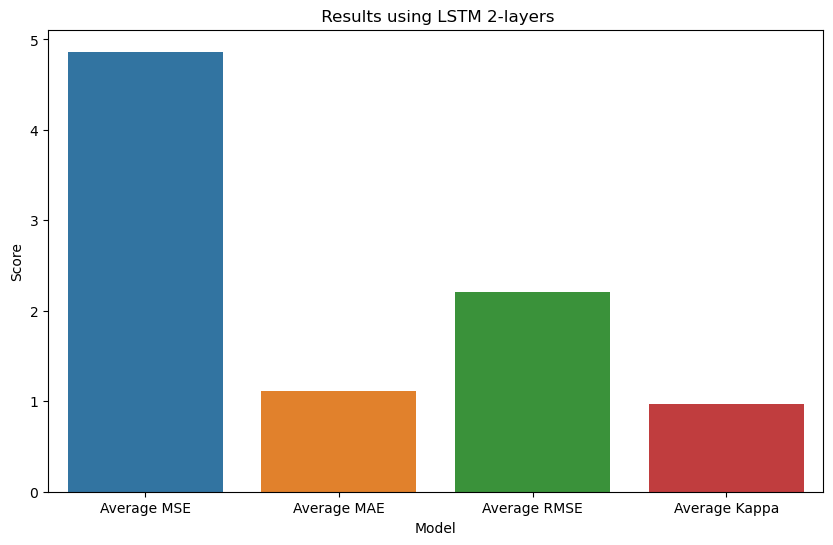

In [15]:
#2-Layer LSTM Model Evaluation
print("Average MSE for LSTM 2-layers: ", np.mean(mse_scores))
print("Average RMSE for LSTM 2-layers: ", np.mean(rmse_scores))
print("Average MAE for LSTM 2-layers: ", np.mean(mae_scores))
print("Average Kappa for LSTM 2-layers: ", np.mean(kappa_scores))

# Visualize results
results = {
    "Average MSE": np.mean(mse_scores),
    "Average MAE": np.mean(mae_scores),
    "Average RMSE": np.mean(rmse_scores),
    "Average Kappa": np.mean(kappa_scores)
}
visualize_results(results, f" Results using LSTM 2-layers")

3-LAYER LSTM MODEL

In [16]:
#3-Layer LSTM Model definition
def get_model3():
    """
    Define a 3-layer Long Short-Term Memory (LSTM) model for regression tasks.

    Returns:
        keras.models.Sequential: A Keras Sequential model representing the defined LSTM model.
    """
    model = Sequential()
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4, return_sequences=True))
    model.add(LSTM(32, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()
    return model


In [17]:
# 3-Layer LSTM Model Training and Testing
kf = KFold(n_splits=5, shuffle=True)
mse_scores = []  # List to store Mean Squared Error (MSE) scores
rmse_scores = []  # List to store Root Mean Squared Error (RMSE) scores
mae_scores = []  # List to store Mean Absolute Error (MAE) scores
kappa_scores = []  # List to store Cohen's Kappa scores

count = 1
for trainkf, testkf in kf.split(df):
    print("\nTraining Fold {}\n".format(count))
    X_train, X_test, y_train, y_test = df.iloc[trainkf], df.iloc[testkf], y.iloc[trainkf], y.iloc[testkf]
        
    # Tokenize essays for training and testing data
    train_essays = [essay.split() for essay in X_train['token_essay']]
    test_essays = [essay.split() for essay in X_test['token_essay']]
                 
    # Initializing variables for Word2Vec model.
    num_features = 300 
    min_word_count = 40
    num_workers = 4
    context = 10
    downsampling = 1e-3

    print("Training Word2Vec Model...")
    
    # Train Word2Vec model on training essays
    model_lstm = Word2Vec(train_essays, 
                     workers=num_workers, 
                     vector_size=num_features, 
                     min_count=min_word_count, 
                     window=context, 
                     sample=downsampling)

    # Save the Word2Vec model
    model_lstm.wv.save_word2vec_format('Models/word2vecmodel_lstm3.bin', binary=True)

    # Generate average feature vectors for training and testing essays
    training_vectors = generate_average_feature_vectors(train_essays, model_lstm, num_features)
    testing_vectors = generate_average_feature_vectors(test_essays, model_lstm, num_features)

    training_vectors = np.array(training_vectors)
    testing_vectors = np.array(testing_vectors)
    
    # Reshape train and test vectors to 3 dimensions. (1 represents one timestep)
    training_vectors = np.reshape(training_vectors, (training_vectors.shape[0], 1, training_vectors.shape[1]))
    testing_vectors = np.reshape(testing_vectors, (testing_vectors.shape[0], 1, testing_vectors.shape[1]))
    
    # Create and train the 3-Layer LSTM model
    lstm_model3 = get_model3()
    lstm_model3.fit(training_vectors, y_train, batch_size=64, epochs=50)
    
    y_pred = lstm_model3.predict(testing_vectors)
    
    # Save the model on the last fold
    if count == 5:
        lstm_model3.save('Models/model_lstm3.h5')
    
    # Round y_pred to the nearest integer.
    y_pred = np.around(y_pred)    
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    kappa = cohen_kappa_score(y_test.values, y_pred, weights='quadratic')
    
    print("Fold {} MSE: {}".format(count, mse))
    print("Fold {} RMSE: {}".format(count, rmse))
    print("Fold {} MAE: {}".format(count, mae))
    print("Fold {} Kappa Score: {}".format(count, kappa))
    
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    kappa_scores.append(kappa)

    count += 1



Training Fold 1

Training Word2Vec Model...
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 1, 300)            721200    
                                                                 
 lstm_11 (LSTM)              (None, 1, 64)             93440     
                                                                 
 lstm_12 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 827089 (3.16 MB)
Trainable params: 827089 (3.16 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________________

163/163 [==============================] - 6s 38ms/step - loss: 8.0692 - mae: 1.4286
Epoch 30/50
163/163 [==============================] - 6s 37ms/step - loss: 7.4491 - mae: 1.3957
Epoch 31/50
163/163 [==============================] - 6s 36ms/step - loss: 7.4489 - mae: 1.4062
Epoch 32/50
163/163 [==============================] - 6s 36ms/step - loss: 7.7053 - mae: 1.4100
Epoch 33/50
163/163 [==============================] - 6s 39ms/step - loss: 7.4527 - mae: 1.3932
Epoch 34/50
163/163 [==============================] - 7s 40ms/step - loss: 7.3325 - mae: 1.4049
Epoch 35/50
163/163 [==============================] - 6s 39ms/step - loss: 7.1431 - mae: 1.3829
Epoch 36/50
163/163 [==============================] - 6s 38ms/step - loss: 7.3382 - mae: 1.3885
Epoch 37/50
163/163 [==============================] - 6s 39ms/step - loss: 7.4652 - mae: 1.3990
Epoch 38/50
163/163 [==============================] - 7s 44ms/step - loss: 7.1875 - mae: 1.3676
Epoch 39/50
163/163 [=====================

C:\Users\yabio\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Fold 5 MSE: 5.788053949903661
Fold 5 RMSE: 2.4058374737092407
Fold 5 MAE: 1.140655105973025
Fold 5 Kappa Score: 0.9626486452830391


Average MSE for LSTM 3-layers:  4.987042196234907
Average RMSE for LSTM 3-layers:  2.230947570648734
Average MAE for LSTM 3-layers:  1.1226881433122249
Average Kappa for LSTM 3-layers:  0.9683334421714644


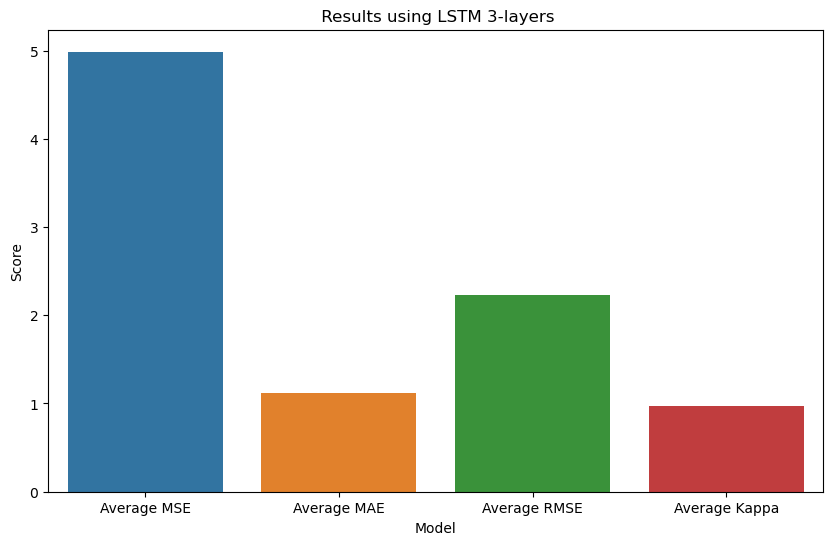

In [18]:
#3-Layer LSTM Model Evaluation
print("Average MSE for LSTM 3-layers: ", np.mean(mse_scores))
print("Average RMSE for LSTM 3-layers: ", np.mean(rmse_scores))
print("Average MAE for LSTM 3-layers: ", np.mean(mae_scores))
print("Average Kappa for LSTM 3-layers: ", np.mean(kappa_scores))


# Visualize results
results = {
    "Average MSE": np.mean(mse_scores),
    "Average MAE": np.mean(mae_scores),
    "Average RMSE": np.mean(rmse_scores),
    "Average Kappa": np.mean(kappa_scores)
}
visualize_results(results, f" Results using LSTM 3-layers")

4-LAYER LSTM MODEL

In [19]:
#4-Layer LSTM Model definition

def get_model4():
    """
    Define a 4-layer Long Short-Term Memory (LSTM) model for regression tasks.

    Returns:
        keras.models.Sequential: A Keras Sequential model representing the defined LSTM model.
    """
    model = Sequential()
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    model.add(LSTM(128, recurrent_dropout=0.4, return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4, return_sequences=True))
    model.add(LSTM(32, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()
    return model


In [20]:
# 4-Layer LSTM Model Training and Testing
kf = KFold(n_splits=5, shuffle=True)
mse_scores = []  # List to store Mean Squared Error (MSE) scores
rmse_scores = []  # List to store Root Mean Squared Error (RMSE) scores
mae_scores = []  # List to store Mean Absolute Error (MAE) scores
kappa_scores = []  # List to store Cohen's Kappa scores

count = 1
for trainkf, testkf in kf.split(df):
    print("\nTraining Fold {}\n".format(count))
    X_train, X_test, y_train, y_test = df.iloc[trainkf], df.iloc[testkf], y.iloc[trainkf], y.iloc[testkf]
        
    # Tokenize essays for training and testing data
    train_essays = [essay.split() for essay in X_train['token_essay']]
    test_essays = [essay.split() for essay in X_test['token_essay']]
                 
    # Initializing variables for Word2Vec model.
    num_features = 300 
    min_word_count = 40
    num_workers = 4
    context = 10
    downsampling = 1e-3

    print("Training Word2Vec Model...")
    
    # Train Word2Vec model on training essays
    model_lstm = Word2Vec(train_essays, 
                     workers=num_workers, 
                     vector_size=num_features, 
                     min_count=min_word_count, 
                     window=context, 
                     sample=downsampling)

    # Save the Word2Vec model
    model_lstm.wv.save_word2vec_format('Models/word2vecmodel_lstm4.bin', binary=True)

    # Generate average feature vectors for training and testing essays
    training_vectors = generate_average_feature_vectors(train_essays, model_lstm, num_features)
    testing_vectors = generate_average_feature_vectors(test_essays, model_lstm, num_features)

    training_vectors = np.array(training_vectors)
    testing_vectors = np.array(testing_vectors)
    
    # Reshape train and test vectors to 3 dimensions. (1 represents one timestep)
    training_vectors = np.reshape(training_vectors, (training_vectors.shape[0], 1, training_vectors.shape[1]))
    testing_vectors = np.reshape(testing_vectors, (testing_vectors.shape[0], 1, testing_vectors.shape[1]))
    
    # Create and train the 4-Layer LSTM model
    lstm_model4 = get_model4()
    lstm_model4.fit(training_vectors, y_train, batch_size=64, epochs=50)
    
    y_pred = lstm_model4.predict(testing_vectors)
    
    # Save the model on the last fold
    if count == 5:
        lstm_model4.save('Models/model_lstm4.h5')
    
    # Round y_pred to the nearest integer.
    y_pred = np.around(y_pred)    
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    kappa = cohen_kappa_score(y_test.values, y_pred, weights='quadratic')
    
    print("Fold {} MSE: {}".format(count, mse))
    print("Fold {} RMSE: {}".format(count, rmse))
    print("Fold {} MAE: {}".format(count, mae))
    print("Fold {} Kappa Score: {}".format(count, kappa))
    
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    kappa_scores.append(kappa)

    count += 1



Training Fold 1

Training Word2Vec Model...
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 1, 300)            721200    
                                                                 
 lstm_26 (LSTM)              (None, 1, 128)            219648    
                                                                 
 lstm_27 (LSTM)              (None, 1, 64)             49408     
                                                                 
 lstm_28 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total pa

163/163 [==============================] - 10s 63ms/step - loss: 7.5340 - mae: 1.4125
Epoch 26/50
163/163 [==============================] - 9s 53ms/step - loss: 8.1797 - mae: 1.4439
Epoch 27/50
163/163 [==============================] - 9s 57ms/step - loss: 7.9648 - mae: 1.4381
Epoch 28/50
163/163 [==============================] - 8s 50ms/step - loss: 8.0422 - mae: 1.4386
Epoch 29/50
163/163 [==============================] - 9s 56ms/step - loss: 7.5807 - mae: 1.4002
Epoch 30/50
163/163 [==============================] - 8s 50ms/step - loss: 7.7506 - mae: 1.4147
Epoch 31/50
163/163 [==============================] - 8s 52ms/step - loss: 8.2936 - mae: 1.4442
Epoch 32/50
163/163 [==============================] - 8s 48ms/step - loss: 7.4828 - mae: 1.3989
Epoch 33/50
163/163 [==============================] - 10s 59ms/step - loss: 7.0947 - mae: 1.3814
Epoch 34/50
163/163 [==============================] - 8s 50ms/step - loss: 7.2124 - mae: 1.3800
Epoch 35/50
163/163 [===================

C:\Users\yabio\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Fold 5 MSE: 5.521387283236995
Fold 5 RMSE: 2.3497632398258754
Fold 5 MAE: 1.1606936416184972
Fold 5 Kappa Score: 0.9615375890741408


Average MSE for LSTM 4-layers:  5.270569157826921
Average RMSE for LSTM 4-layers:  2.2939248730203774
Average MAE for LSTM 4-layers:  1.1437282197897463
Average Kappa for LSTM 4-layers:  0.9657658537334187


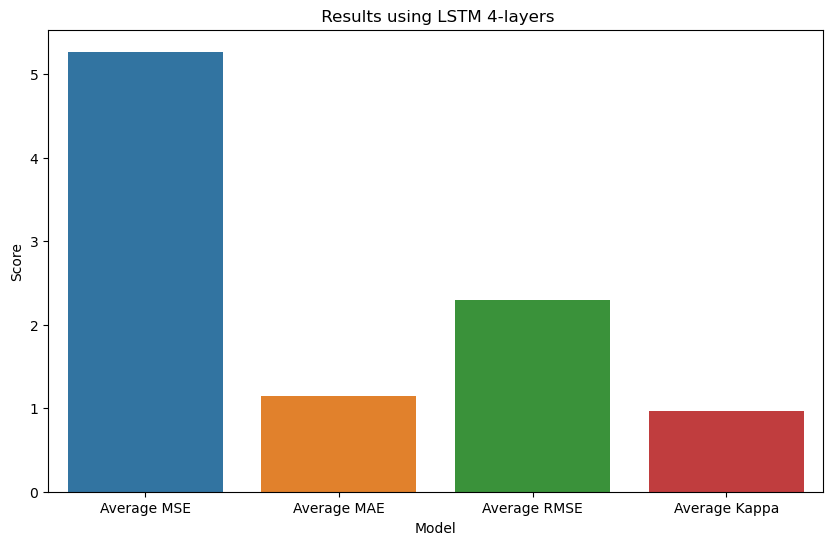

In [21]:
#4-Layer LSTM Model Evaluation
print("Average MSE for LSTM 4-layers: ", np.mean(mse_scores))
print("Average RMSE for LSTM 4-layers: ", np.mean(rmse_scores))
print("Average MAE for LSTM 4-layers: ", np.mean(mae_scores))
print("Average Kappa for LSTM 4-layers: ", np.mean(kappa_scores))


# Visualize results
results = {
    "Average MSE": np.mean(mse_scores),
    "Average MAE": np.mean(mae_scores),
    "Average RMSE": np.mean(rmse_scores),
    "Average Kappa": np.mean(kappa_scores)
}
visualize_results(results, f" Results using LSTM 4-layers")


Contribution 3: Exploring the Effect of Grade Normalization on Performance of AEG Models

<Axes: xlabel='score', ylabel='Count'>

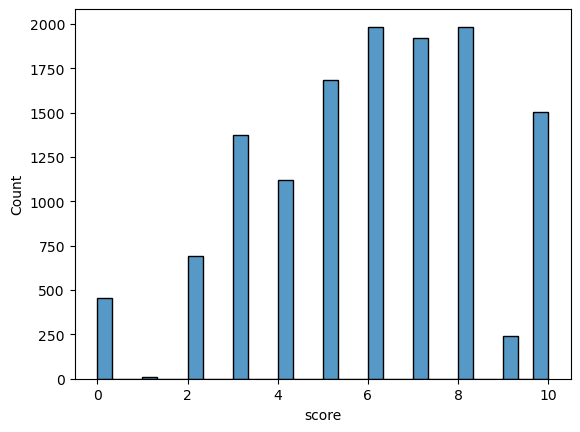

In [22]:
# Normalizing Grades and Setting the y labels to the normalized grades

# Define the minimum and maximum possible scores for each essay set
min_range = [2, 1, 0, 0, 0, 0, 2, 10]
max_range = [12, 6, 3, 3, 4, 4, 24, 60]

# Function to normalize a score to a range of 0 to 10
def normalize(score, min_val, max_val):
    normalized = np.interp(score, [min_val, max_val], [0, 10])
    return round(normalized)

# Apply the normalization function to the 'grade' column for each essay set
df['score'] = df.apply(lambda x: normalize(x['grade'], min_range[x['essay_set'] - 1], max_range[x['essay_set'] - 1]), axis=1)


# Set y labels to the normalized scores
y = df['score']

# Check the skewness of the normalized scores and plot a histogram
sns.histplot(df['score'])


In [23]:
# 2-Layer LSTM Model Training and Testing using Normalized Grades

# Initialize K-Fold cross-validation with 5 folds
kf = KFold(n_splits=5, shuffle=True)

# Lists to store evaluation metrics for each fold
mse_scores = []  # Mean Squared Error (MSE)
rmse_scores = []  # Root Mean Squared Error (RMSE)
mae_scores = []  # Mean Absolute Error (MAE)
kappa_scores = []  # Cohen's Kappa scores

count = 1  # Initialize fold counter
for trainkf, testkf in kf.split(df):
    print("\nTraining Fold {}\n".format(count))
    X_train, X_test, y_train, y_test = df.iloc[trainkf], df.iloc[testkf], y.iloc[trainkf], y.iloc[testkf]
        
    train_essays = [essay.split() for essay in X_train['token_essay']]
    test_essays = [essay.split() for essay in X_test['token_essay']]
                 
    # Initializing variables for Word2Vec model.
    num_features = 300 
    min_word_count = 40
    num_workers = 4
    context = 10
    downsampling = 1e-3

    print("Training Word2Vec Model...")
    model_lstm = Word2Vec(train_essays, 
                     workers=num_workers, 
                     vector_size=num_features, 
                     min_count=min_word_count, 
                     window=context, 
                     sample=downsampling)

    model_lstm.wv.save_word2vec_format('Models/word2vecmodel_lstm_score.bin', binary=True)

    training_vectors = generate_average_feature_vectors(train_essays, model_lstm, num_features)
    testing_vectors = generate_average_feature_vectors(test_essays, model_lstm, num_features)

    training_vectors = np.array(training_vectors)
    testing_vectors = np.array(testing_vectors)
    
    # Reshape train and test vectors to 3 dimensions (1 represents one timestep)
    training_vectors = np.reshape(training_vectors, (training_vectors.shape[0], 1, training_vectors.shape[1]))
    testing_vectors = np.reshape(testing_vectors, (testing_vectors.shape[0], 1, testing_vectors.shape[1]))
    
    # Create and train the LSTM model
    lstm_model_score = get_model()
    lstm_model_score.fit(training_vectors, y_train, batch_size=64, epochs=50)
    
    # Make predictions with the model
    y_pred = lstm_model_score.predict(testing_vectors)
    
    if count == 5:
        # Save the trained model after the final fold
        lstm_model_score.save('Models/model_lstm_score.h5')
    
    # Round y_pred to the nearest integer
    y_pred = np.around(y_pred)    
    
    # Calculate evaluation metrics for this fold
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    kappa = cohen_kappa_score(y_test.values, y_pred, weights='quadratic')
    
    print("Fold {} MSE: {}".format(count, mse))
    print("Fold {} RMSE: {}".format(count, rmse))
    print("Fold {} MAE: {}".format(count, mae))
    print("Fold {} Kappa Score: {}".format(count, kappa))
    
    # Store evaluation metrics for this fold
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    kappa_scores.append(kappa)

    count += 1 



Training Fold 1

Training Word2Vec Model...
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_45 (LSTM)              (None, 1, 300)            721200    
                                                                 
 lstm_46 (LSTM)              (None, 64)                93440     
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 814705 (3.11 MB)
Trainable params: 814705 (3.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
163/163 [==============================] - 14s 39ms/step - loss: 7.7385 - mae: 2.1789
Epoch 2

163/163 [==============================] - 6s 37ms/step - loss: 3.3248 - mae: 1.4215
Epoch 35/50
163/163 [==============================] - 6s 38ms/step - loss: 3.3134 - mae: 1.4239
Epoch 36/50
163/163 [==============================] - 6s 39ms/step - loss: 3.3070 - mae: 1.4194
Epoch 37/50
163/163 [==============================] - 6s 39ms/step - loss: 3.2563 - mae: 1.4086
Epoch 38/50
163/163 [==============================] - 7s 44ms/step - loss: 3.2971 - mae: 1.4169
Epoch 39/50
163/163 [==============================] - 6s 36ms/step - loss: 3.2275 - mae: 1.4067
Epoch 40/50
163/163 [==============================] - 6s 35ms/step - loss: 3.2208 - mae: 1.4022
Epoch 41/50
163/163 [==============================] - 6s 35ms/step - loss: 3.1955 - mae: 1.3966
Epoch 42/50
163/163 [==============================] - 8s 50ms/step - loss: 3.2167 - mae: 1.3994
Epoch 43/50
163/163 [==============================] - 7s 44ms/step - loss: 3.1951 - mae: 1.3882
Epoch 44/50
163/163 [=====================

                                                                 
 lstm_54 (LSTM)              (None, 64)                93440     
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 814705 (3.11 MB)
Trainable params: 814705 (3.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
163/163 [==============================] - 12s 45ms/step - loss: 7.4974 - mae: 2.1407
Epoch 2/50
163/163 [==============================] - 16s 100ms/step - loss: 5.1582 - mae: 1.7895
Epoch 3/50
163/163 [==============================] - 10s 60ms/step - loss: 4.8977 - mae: 1.7442
Epoch 4/50
163/163 [==============================] - 8s 51ms/step - loss: 4.7

C:\Users\yabio\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Average MSE for LSTM 2-layers with normalized Grades:  3.24938999082626
Average RMSE for LSTM 2-layers with normalized Grades:  1.802471324917775
Average MAE for LSTM 2-layers with normalized Grades:  1.3457166947222792
Average Kappa for LSTM 2-layers with normalized Grades:  0.6760251239641214


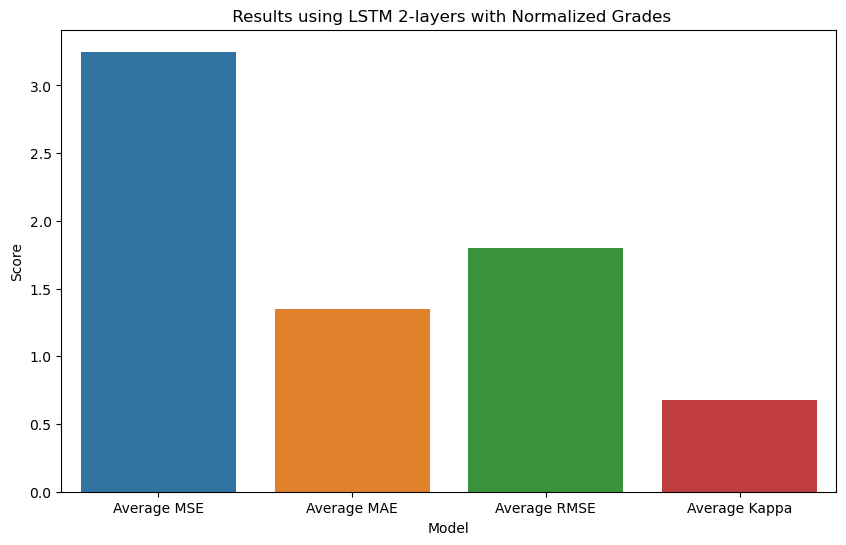

In [24]:
#2-Layer LSTM Model Evaluation using Normalized grades at the y value
print("Average MSE for LSTM 2-layers with normalized Grades: ", np.mean(mse_scores))
print("Average RMSE for LSTM 2-layers with normalized Grades: ", np.mean(rmse_scores))
print("Average MAE for LSTM 2-layers with normalized Grades: ", np.mean(mae_scores))
print("Average Kappa for LSTM 2-layers with normalized Grades: ", np.mean(kappa_scores))


# Visualize results
results = {
    "Average MSE": np.mean(mse_scores),
    "Average MAE": np.mean(mae_scores),
    "Average RMSE": np.mean(rmse_scores),
    "Average Kappa": np.mean(kappa_scores)
}
visualize_results(results, f" Results using LSTM 2-layers with Normalized Grades")